In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [30]:
from prefect import Flow, Parameter
import pandas as pd
from prefect.engine.executors import DaskExecutor

In [4]:
input_df = pd.read_csv("../data/house-prices-advanced-regression-techniques/train.csv")
test= pd.read_csv("../data/house-prices-advanced-regression-techniques/test.csv")

In [33]:
from ml_flow import *
with Flow("data_cleaning") as flow:
    input_data = Parameter("input_data")
    problem, target, features = Parameter("problem"), Parameter("target"), Parameter("features")
    train_valid_split = extract_train_valid_split(input_data = input_data, problem = problem, target = target)
    train_data = extract_train_data(train_valid_split)
    valid_data = extract_valid_data(train_valid_split)
    nan_features = extract_nan_features(input_data)
    problematic_features = extract_problematic_features(input_data)
    undefined_features = extract_undefined_features(input_data, features, target,nan_features,problematic_features)
    
    numeric_features = extract_numeric_features(input_data,undefined_features)
    categorical_features = extract_categorical_features(input_data,undefined_features)
    missing_indicator = fit_missing_indicator(train_data,undefined_features)
    
    train_transformed_missing = transform_missing_indicator_df(train_data, undefined_features,missing_indicator)
    valid_transformed_missing = transform_missing_indicator_df(valid_data,undefined_features,missing_indicator)
    
    #numeric columns work
    numeric_imputer = fit_numeric_imputer(train_data,numeric_features)
    imputed_train_numeric_df = impute_numeric_df(numeric_imputer,train_data,numeric_features)
    imputed_valid_numeric_df = impute_numeric_df(numeric_imputer,valid_data,numeric_features)
    
    yeo_johnson_transformer = fit_yeo_johnson_transformer(imputed_train_numeric_df)
    yeo_johnson_train_transformed = transform_yeo_johnson_transformer(imputed_train_numeric_df,yeo_johnson_transformer)
    yeo_johnson_valid_transformed = transform_yeo_johnson_transformer(imputed_valid_numeric_df,yeo_johnson_transformer)
    
    #categorical columns work
    categorical_imputer = fit_categorical_imputer(train_data,categorical_features)
    imputed_train_categorical_df = transform_categorical_data(train_data,categorical_features,categorical_imputer)
    imputed_valid_categorical_df = transform_categorical_data(valid_data,categorical_features,categorical_imputer)
    
    target_transformer = fit_target_transformer(problem,target,train_data)
    transformed_train_target = transform_target(problem,target,train_data,target_transformer)
    transformed_valid_target = transform_target(problem,target,valid_data,target_transformer)
    
    target_encoder_transformer = fit_target_encoder(imputed_train_categorical_df,transformed_train_target)
    target_encoded_train_df = target_encoder_transform(target_encoder_transformer,imputed_train_categorical_df)
    target_encoded_valid_df = target_encoder_transform(target_encoder_transformer,imputed_valid_categorical_df)
    
    #merge_data
    transformed_train_df = merge_transformed_data(target_encoded_train_df, yeo_johnson_train_transformed,train_transformed_missing)
    transformed_valid_df = merge_transformed_data(target_encoded_valid_df, yeo_johnson_valid_transformed, valid_transformed_missing)
    
    #outlierness
    hbos_transformer = fit_hbos_transformer(transformed_train_df)
    hbos_transform_train_data = hbos_transform(transformed_train_df,hbos_transformer)
    hbos_transform_valid_data = hbos_transform(transformed_valid_df,hbos_transformer)
    
    #merge outlierness
    transformed_train_df = merge_hbos_df(transformed_train_df,hbos_transform_train_data)
    transformed_valid_df = merge_hbos_df(transformed_valid_df,hbos_transform_valid_data)
    
    



In [34]:
executor = DaskExecutor()
flow_state = flow.run(
    input_data= input_df, 
    problem="regression", 
    target = "SalePrice", 
    features = "infer",
    executor=executor
)

[2020-02-17 02:46:00,925] INFO - prefect.FlowRunner | Beginning Flow run for 'data_cleaning'
[2020-02-17 02:46:00,927] INFO - prefect.FlowRunner | Starting flow run.
[2020-02-17 02:46:01,051] INFO - prefect.TaskRunner | Task 'problem': Starting task run...
[2020-02-17 02:46:01,058] INFO - prefect.TaskRunner | Task 'problem': finished task run for task with final state: 'Success'
[2020-02-17 02:46:01,123] INFO - prefect.TaskRunner | Task 'features': Starting task run...
[2020-02-17 02:46:01,133] INFO - prefect.TaskRunner | Task 'features': finished task run for task with final state: 'Success'
[2020-02-17 02:46:01,281] INFO - prefect.TaskRunner | Task 'input_data': Starting task run...
[2020-02-17 02:46:01,340] INFO - prefect.TaskRunner | Task 'input_data': finished task run for task with final state: 'Success'
[2020-02-17 02:46:01,763] INFO - prefect.TaskRunner | Task 'target': Starting task run...
[2020-02-17 02:46:01,808] INFO - prefect.TaskRunner | Task 'target': finished task run f

/mnt/e/projects/crawto/venv/lib/python3.6/site-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


[2020-02-17 02:46:04,634] INFO - prefect.TaskRunner | Task 'fit_target_encoder': finished task run for task with final state: 'Success'
[2020-02-17 02:46:04,648] INFO - prefect.TaskRunner | Task 'target_encoder_transform': Starting task run...
[2020-02-17 02:46:04,651] INFO - prefect.TaskRunner | Task 'target_encoder_transform': Starting task run...
[2020-02-17 02:46:04,836] INFO - prefect.TaskRunner | Task 'target_encoder_transform': finished task run for task with final state: 'Success'
[2020-02-17 02:46:04,865] INFO - prefect.TaskRunner | Task 'target_encoder_transform': finished task run for task with final state: 'Success'
[2020-02-17 02:46:04,884] INFO - prefect.TaskRunner | Task 'fit_yeo_johnson_transformer': finished task run for task with final state: 'Success'
[2020-02-17 02:46:04,896] INFO - prefect.TaskRunner | Task 'transform_yeo_johnson_transformer': Starting task run...
[2020-02-17 02:46:04,899] INFO - prefect.TaskRunner | Task 'transform_yeo_johnson_transformer': Starti

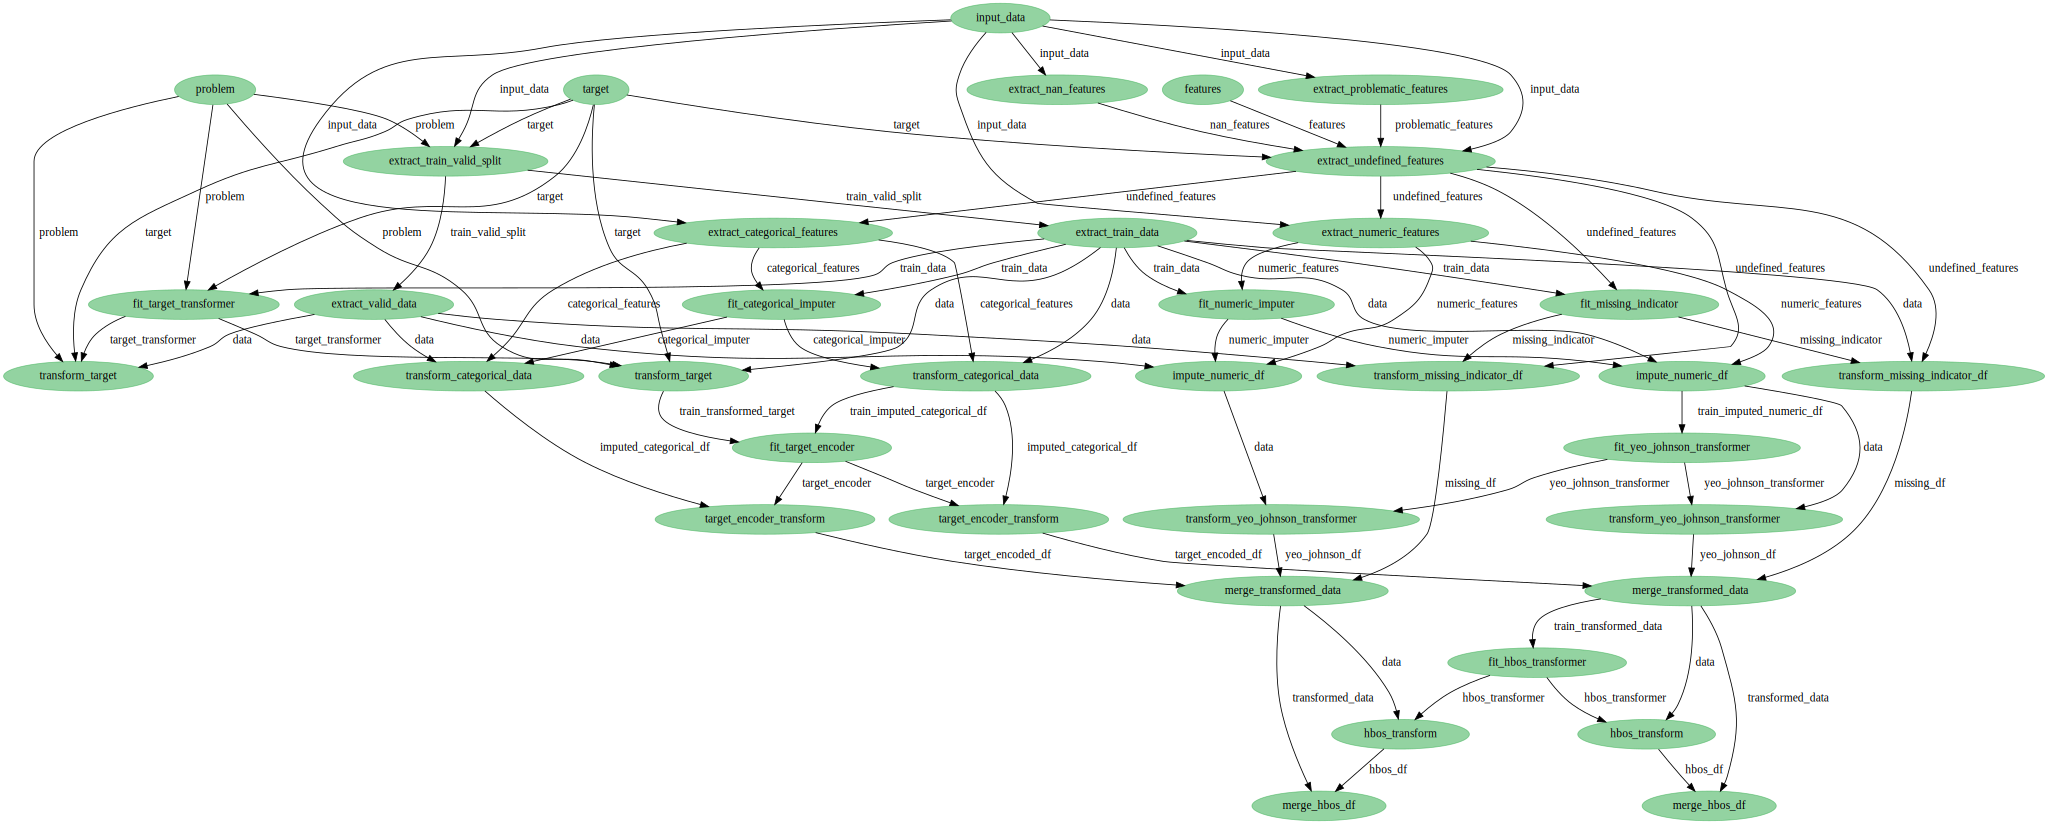

In [35]:
flow.visualize(flow_state=flow_state)